### Transfer Learning with Pytorch

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Thu Mar 25 15:09:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /etc/*-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"
NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [3]:
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=0788b080c97ef9c6543ab69e2f2bd9cdd79690dafa4b246fa68c988f7f3c6fa8
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [4]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
# Execute function
mem_report()

CPU RAM Free: 12.8 GB
GPU 0 ... Mem Free: 11441MB / 11441MB | Utilization   0%


In [5]:
import os
import shutil
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

In [6]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/gdrive', force_remount=True)
# root_path = 'gdrive/My Drive/Colab Notebooks/Classif_img_CNN/datas/'
root_path = 'gdrive/My Drive/Formation simplon/Brief_image_classif_CNN/datas/'

unset HISTFILE; export PS1="root@978aa429836f-91e722ff2d2c41deba4c80a085e1e9a0: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@978aa429836f-91e722ff2d2c41deba4c80a085e1e9a0: umount -f /content/gdrive || umount /content/gdrive; pkill -9 -x drive
umount: /content/gdrive: no mount point specified.
umount: /content/gdrive: no mount point specified.
root@978aa429836f-91e722ff2d2c41deba4c80a085e1e9a0: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@978aa429836f-91e722ff2d2c41deba4c80a085e1e9a0: ( while `sleep 0.5`; do if [[ -d "/content/gdrive" && "$(ls -A /content/gdrive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 137
root@978aa429836f-91e722ff2d2c41deba4c80a085e1e9a0: cat /tmp/tmpo4h63rqo/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_insta

In [7]:
file = ''.join(root_path+'AnimalFace.zip')
file

'gdrive/My Drive/Formation simplon/Brief_image_classif_CNN/datas/AnimalFace.zip'

In [8]:
!mkdir datas
import zipfile
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall("datas")

In [9]:
IMG_SIZE = 128

In [10]:
# train folders
os.mkdir('/content/datas/train/')
for img_class in os.listdir("/content/datas/Image"):
    os.mkdir('/content/datas/train/' + img_class[:-4] + '/')

In [11]:
# test folders
os.mkdir('/content/datas/test/')
for img_class in os.listdir("/content/datas/Image"):
    os.mkdir('/content/datas/test/' + img_class[:-4] + '/')

In [12]:
# form train dataset
for img_class in tqdm(os.listdir('/content/datas/Image/')):
    img_ls = os.listdir('/content/datas/Image/' + img_class)
    for img in img_ls[:int(len(img_ls) * 0.8)]:
        shutil.copy('/content/datas/Image/' + img_class + '/' + img, 
                    '/content/datas/train/' + img_class[:-4] + '/' + img)

100%|██████████| 21/21 [00:00<00:00, 93.20it/s]


In [13]:
# form test dataset
for img_class in tqdm(os.listdir('/content/datas/Image/')):
    img_ls = os.listdir('/content/datas/Image/' + img_class)
    for img in img_ls[int(len(img_ls) * 0.8):]:
        shutil.copy('/content/datas/Image/' + img_class + '/' + img, 
                    '/content/datas/test/' + img_class[:-4] + '/' + img)

100%|██████████| 21/21 [00:00<00:00, 352.11it/s]


In [14]:
train_data_path = "/content/datas/train/"
test_data_path = "/content/datas/test/"

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ])

# this function get folder with images
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=transform)

test_data = torchvision.datasets.ImageFolder(root=test_data_path,
                                             transform=transform)

In [15]:
batch_size=64
train_data_loader = data.DataLoader(train_data, shuffle=True,
                                    batch_size=batch_size)

test_data_loader  = data.DataLoader(test_data, shuffle=True, 
                                    batch_size=batch_size)

In [16]:
class_names = train_data.classes

In [17]:
from torchvision import models
# download pretrained ResNet
transfer_model = models.resnet50(pretrained=True)

# freeze all layers in pretrained model
for name, param in transfer_model.named_parameters():
    param.requires_grad = False
    
# replace last layer 
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500),
nn.ReLU(),
nn.Dropout(), nn.Linear(500, len(class_names)))

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"device : {device} (gpu)")
else:
    device = torch.device("cpu")
    print(f"device : {device}")

print(transfer_model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



device : cuda (gpu)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

## C'est long... très long ... bon c'est normal le resnet a 50 couches

In [18]:
model = transfer_model 
model.to(device)
# add optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0003, amsgrad=True)
epochs = 50
loss_fn = torch.nn.CrossEntropyLoss()
loss_lst, loss_val_lst = [], []

for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_data_loader:
        optimizer.zero_grad()
        inputs, target = batch
        inputs = inputs.to(device)
        target = target.to(device)
        output = model(inputs)
        
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        training_loss += loss.data.item()
    loss_lst.append(training_loss)

    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in test_data_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        loss = loss_fn(output,targets)
        valid_loss += loss.data.item()
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1],
                        targets).view(-1)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    loss_val_lst.append(valid_loss)

    print('Epoch: {}, Training Loss: {:.2f}, \
        Validation Loss: {:.2f}, \
        accuracy = {:.2f}'.format(epoch, training_loss, \
        valid_loss, num_correct / num_examples))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 60.57,         Validation Loss: 7.16,         accuracy = 0.82
Epoch: 1, Training Loss: 24.06,         Validation Loss: 4.07,         accuracy = 0.89
Epoch: 2, Training Loss: 16.14,         Validation Loss: 3.15,         accuracy = 0.90
Epoch: 3, Training Loss: 12.38,         Validation Loss: 2.82,         accuracy = 0.91
Epoch: 4, Training Loss: 9.83,         Validation Loss: 2.42,         accuracy = 0.92
Epoch: 5, Training Loss: 8.76,         Validation Loss: 2.34,         accuracy = 0.93
Epoch: 6, Training Loss: 7.81,         Validation Loss: 2.07,         accuracy = 0.93
Epoch: 7, Training Loss: 7.37,         Validation Loss: 2.09,         accuracy = 0.92
Epoch: 8, Training Loss: 6.17,         Validation Loss: 2.01,         accuracy = 0.93
Epoch: 9, Training Loss: 5.28,         Validation Loss: 2.05,         accuracy = 0.92
Epoch: 10, Training Loss: 5.54,         Validation Loss: 1.93,         accuracy = 0.93
Epoch: 11, Training Loss: 5.15,         Validatio

In [19]:
# Specify a path to save to
PATH = "/content/gdrive/MyDrive/Formation simplon/Brief_image_classif_CNN/CNN_simple_pytorch.pt"

# Save
torch.save(model.state_dict(), PATH)

# # Load
# device = torch.device('cpu')
# model = Net()
# model.load_state_dict(torch.load(PATH, map_location=device))

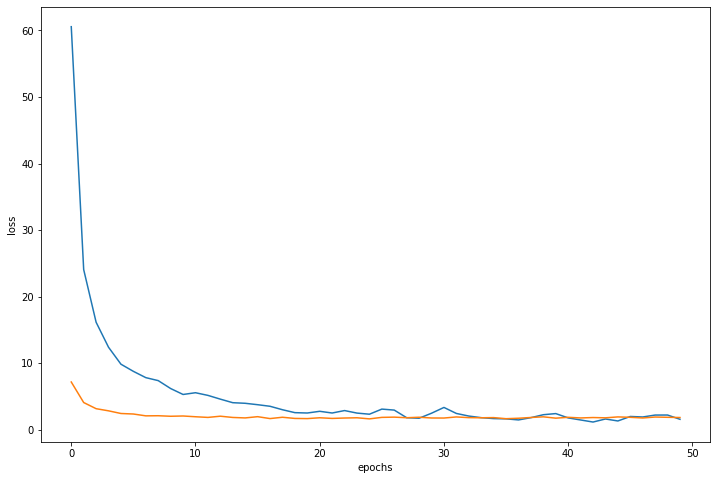

In [20]:
plt.figure(figsize=[12, 8])
plt.plot(range(len(loss_lst)), loss_lst);
plt.plot(range(len(loss_val_lst)), loss_val_lst);
plt.xlabel('epochs');
plt.ylabel('loss');

### Confusion matrix

In [21]:
all_output = np.array([])
all_targets = np.array([])

for batch in tqdm(test_data_loader):
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    all_output = np.concatenate([all_output, output.max(dim=1).indices.cpu().numpy()])
    all_targets = np.concatenate([all_targets, targets.numpy()])

100%|██████████| 8/8 [00:02<00:00,  3.87it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


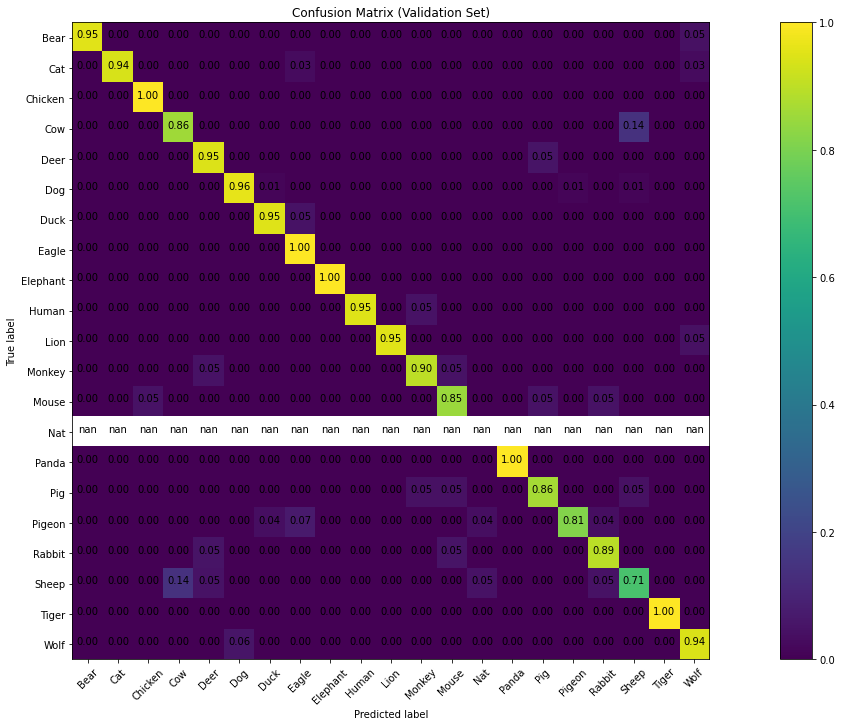

In [22]:
# plot confusion matrix
conf_matr = confusion_matrix(all_output, 
                             all_targets)
import itertools
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig('./figures/conf_matrix.png')

plt.figure(figsize=(20,10))
plot_confusion_matrix(conf_matr, labels=class_names, cmap='viridis')

In [29]:
from skimage.transform import resize
from google.colab import files
image = files.upload()
print(image.keys())
for k, v in image.items(): pass

Saving 120d9eb479.jpeg to 120d9eb479.jpeg
dict_keys(['120d9eb479.jpeg'])


(-0.5, 127.5, 127.5, -0.5)

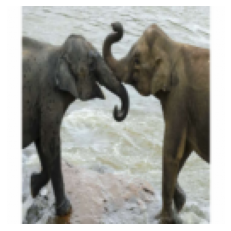

In [30]:
from skimage.io import imread
from skimage.transform import resize
im = imread(k) # 333636a798.jpeg ## fda9a545f5.jpeg
im = resize(im, (IMG_SIZE, IMG_SIZE))
plt.imshow(im)
plt.axis('off')

In [31]:
from torch.autograd import Variable
from PIL import Image

# An instance of your model.
img_pil = Image.open(k)
#img_pil.show()
img_tensor = transform(img_pil).float()
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.cuda()

fc_out = model(Variable(img_tensor))

output = fc_out.cpu().detach().numpy()
print(class_names[output.argmax()])

Elephant
